#### Assumptions
* CAPEX are distributed via the allocation factors, allocation starts immediately in startyear
* CAPEX is escalated with escalation factors
* escalation values start on the start year (if startyear is 2023, then the CAPEX values are 1.02 * Capex values)
* OPEX values are the sum of the escalated CAPEX values, and OPEX values are themselves not escalated

#### Potential to do's
* add geographical data to the system objects (to plot them in space, but also to possibly calculate distances)
* add 'owner' per system object (is the business case for each stakeholder positive?)
* now in case of an error, a default value is returned. The exeptions should return a clear error statement
* develop tests
* check what are now input fields and what is read from the xls (make sure this is handeled properly

#### 0. Import basic methods from source.py
Import useful methods from source.py (NB: can later be integrated into a package)

In [1]:
from source import *

#### 1. Open xls file and ingest Inputs table
Note I am assuming that all inputs will be aggregated into one single inputs table

In [2]:
filename = r'H2 Model - Input sheet.xlsm'

In [3]:
%%time
# load workbook
wb = load_workbook(filename)

CPU times: total: 234 ms
Wall time: 334 ms


In [4]:
# load worksheet
ws = wb["Input Tab"]

In [5]:
mapping = {}

for entry, data_boundary in ws.tables.items():
    # parse the data within the ref boundary
    data = ws[data_boundary]
    
    # extract the data (the inner list comprehension gets the values for each cell in the table)
    content = [[cell.value for cell in ent] for ent in data]
    
    # find header
    header = content[0]
    
    # find the rest ... the contents, excluding the header
    rest = content[1:]
    
    # create dataframe with the column names
    # and pair table name with dataframe
    df = pd.DataFrame(rest, columns = header)
    mapping[entry] = df

In [6]:
Inputs = pd.DataFrame(mapping['Scenario1'])
Inputs.head()

,Category,Sub-system,Element,Component,Description,Number,Unit,Comments
0,System input,Wind energy source & Transport,Offshore wind park,-,Total Windpark Capacity,3000,MW,None
1,System input,Wind energy source & Transport,Offshore wind park,Turbine,Windturbine Capacity per unit,20,MW,None
2,System input,Wind energy source & Transport,Offshore wind park,Inter-array cable,Length,50,km,None
3,System input,AC Substation & Transport,AC Substation & Transport,AC Substation,Capacity per unit,2000,MW,None
4,System input,AC Substation & Transport,AC Substation & Transport,AC collection cable,Length,25,km,None


#### 2. Data inspection 

In [7]:
Inputs.columns

Index(['Category', 'Sub-system', 'Element', 'Component', 'Description',
       'Number', 'Unit', 'Comments'],
      dtype='object')

In [8]:
Inputs[Inputs['Sub-system']=='Wind energy source & Transport'].head()

,Category,Sub-system,Element,Component,Description,Number,Unit,Comments
0,System input,Wind energy source & Transport,Offshore wind park,-,Total Windpark Capacity,3000,MW,None
1,System input,Wind energy source & Transport,Offshore wind park,Turbine,Windturbine Capacity per unit,20,MW,None
2,System input,Wind energy source & Transport,Offshore wind park,Inter-array cable,Length,50,km,None
14,System input,Wind energy source & Transport,Offshore wind park,Inter-array cable,Transport loss,0.02,%,None
23,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Foundation & cable costs (Development and Proj...,207000,EUR / MW,"0,1 * Foundation procurement"


In [9]:
list(Inputs['Sub-system'].unique())

['Wind energy source & Transport',
 'AC Substation & Transport',
 'Converter & Transport',
 'Electrolysis, Electricity & Transport',
 '-']

In [10]:
list(Inputs['Element'].unique())

['Offshore wind park',
 'AC Substation & Transport',
 'Converter',
 'Electrolysis',
 'Electricity',
 'Facility location',
 'Transport',
 '-']

In [11]:
list(Inputs['Component'].unique())

['-',
 'Turbine',
 'Inter-array cable',
 'AC Substation',
 'AC collection cable',
 'HVDC Converter',
 'HVDC cable',
 'Electrolyser',
 'DCAC Converter',
 'Artificial island',
 'Mainland',
 'H2 Pipeline',
 'Electricity cable',
 'HVDC Cable',
 'Foundation & cable',
 'DC collection cable',
 'Desalination unit',
 'Compressor unit',
 'Storage unit',
 'Compressor after storage']

#### 3. Select one item from the Inputs table (generate cashflow overview)

##### A. do per item

In [12]:
subsystem='Wind energy source & Transport'
element='Offshore wind park'
component='Foundation & cable'

Inputs[
    (Inputs['Sub-system'] == subsystem) &
    (Inputs['Element'] == element) &
    (Inputs['Component'] == component) 
]

,Category,Sub-system,Element,Component,Description,Number,Unit,Comments
23,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Foundation & cable costs (Development and Proj...,207000,EUR / MW,"0,1 * Foundation procurement"
24,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Foundation & cable costs (Procurement),2070000,EUR / MW,"1,8 * Turbine procurement"
25,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Foundation & cable costs (Installation and Com...,414000,EUR / MW,"0,2 * Foundation procurement"
26,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Number of units,3000,MW,Unit = MW
27,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Construction duration,3,years,None
28,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Share of Investments in Year 1,0.4,% of Capex total,None
29,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Share of Investments in Year 2,0.3,% of Capex total,None
30,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Share of Investments in Year 3,0.3,% of Capex total,None
31,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Economic Lifetime,50,years,None
32,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Depreciation Flag,1,flag,None


In [13]:
%%time
df_Foundations = Inputs_2_cashflow(Inputs, 
                                   startyear=2023,
                                   lifecycle=50,
                                   subsystem='Wind energy source & Transport',
                                   element='Offshore wind park',
                                   component='Foundation & cable',
                                   Debug=True)
df_Foundations.head()

'Escalation base year Foundation & cable: 2023'

'Escalation rate Foundation & cable: 0.02'

'Number of units Foundation & cable: 3000 MW'

'Construction duration Foundation & cable: 3 years'

'Construction allocation Foundation & cable: [0.4, 0.3, 0.3] per year'

'Economic Lifetime Foundation & cable: 50 years'

'Depreciation Flag Foundation & cable: 1'

'Yearly Variable Costs Flag Foundation & cable: 1'

'Yearly Variable Costs Rate Foundation & cable: 0.03'

'Insurance Flag Foundation & cable: 1'

'Insurance Rate Foundation & cable: 0.005'

'Decommissioning Foundation & cable: 0.02'

'Residual Value Foundation & cable: 0.01'

'Escalation years: [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072]'

'Escalation values: [1.02, 1.0404, 1.061208, 1.08243216, 1.1040808032, 1.126162419264, 1.14868566764928, 1.1716593810022657, 1.195092568622311, 1.2189944199947573, 1.2433743083946525, 1.2682417945625455, 1.2936066304537963, 1.3194787630628724, 1.3458683383241299, 1.3727857050906125, 1.4002414191924248, 1.4282462475762734, 1.4568111725277988, 1.485947395978355, 1.515666343897922, 1.5459796707758806, 1.5768992641913981, 1.6084372494752261, 1.6406059944647307, 1.6734181143540252, 1.7068864766411058, 1.741024206173928, 1.7758446902974065, 1.8113615841033548, 1.847588815785422, 1.8845405921011305, 1.9222314039431532, 1.9606760320220162, 1.9998895526624565, 2.0398873437157055, 2.08068509059002, 2.1222987924018204, 2.164744768249857, 2.208039663614854, 2.252200456887151, 2.297244466024894, 2.343189355345392, 2.3900531424522997, 2.437854205301346, 2.4866112894073726, 2.53634351519552, 2.5870703854994304, 2.638811793209419, 2.6915880290736074]'

'CAPEX total Foundation & cable: 2691000 eu per MW'

'CAPEX years: [2023, 2024, 2025]'

'CAPEX values: [-3229200000.0, -2421900000.0, -2421900000.0]'

'CAPEX years escalated: [2023, 2024, 2025]'

'CAPEX values escalated: [-3293784000.0, -2519744760.0, -2570139655.2]'

'OPEX value: -293428394.53199995'

'OPEX years escalated: [2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072]'

'OPEX values escalated: [-317616330.89860487, -323968657.516577, -330448030.66690856, -337056991.28024673, -343798131.10585165, -350674093.7279687, -357687575.6025281, -364841327.11457866, -372138153.65687025, -379580916.7300076, -387172535.0646078, -394915985.76589996, -402814305.481218, -410870591.59084237, -419088003.4226592, -427469763.4911124, -436019158.76093465, -444739541.9361534, -453634332.7748765, -462707019.43037397, -471961159.81898147, -481400383.01536113, -491028390.6756683, -500848958.4891817, -510865937.65896535, -521083256.41214466, -531504921.5403876, -542135019.9711953, -552977720.3706193, -564037274.7780317, -575318020.2735924, -586824380.6790642, -598560868.2926455, -610532085.6584984, -622742727.3716685, -635197581.9191018, -647901533.5574838, -660859564.2286335, -674076755.5132061, -687558290.6234703, -701309456.4359397, -715335645.5646585, -729642358.4759517, -744235205.6454706, -759119909.75838, -774302307.9535477, -789788354.1126186]'

0
2023
-3293784000.0
1
2024
-2519744760.0
2
2025
-2570139655.2
CPU times: total: 78.1 ms
Wall time: 61.2 ms


,years,capex,opex,revenue
years,,,,
2023,2023,-3.293784e+09,0.000000e+00,0
2024,2024,-2.519745e+09,0.000000e+00,0
2025,2025,-2.570140e+09,0.000000e+00,0
2026,2026,0.000000e+00,-3.176163e+08,0
2027,2027,0.000000e+00,-3.239687e+08,0


In [18]:
%%time
df_npv_Foundations = calculate_npv(df_Foundations)
df_npv_Foundations.head()

CPU times: total: 0 ns
Wall time: 1.02 ms


,years,capex,opex,revenue,cashflow,cashflow_sum,npv,npv_sum
years,,,,,,,,
2023,2023,-3.293784e+09,0.000000e+00,0,-3.293784e+09,-3.293784e+09,-6.948135e+08,-6.948135e+08
2024,2024,-2.519745e+09,0.000000e+00,0,-2.519745e+09,-5.813529e+09,-4.967592e+08,-1.191573e+09
2025,2025,-2.570140e+09,0.000000e+00,0,-2.570140e+09,-8.383668e+09,-4.735461e+08,-1.665119e+09
2026,2026,0.000000e+00,-3.176163e+08,0,-3.176163e+08,-8.701285e+09,-5.469210e+07,-1.719811e+09
2027,2027,0.000000e+00,-3.239687e+08,0,-3.239687e+08,-9.025253e+09,-5.213640e+07,-1.771947e+09


CPU times: total: 1.86 s
Wall time: 2.01 s


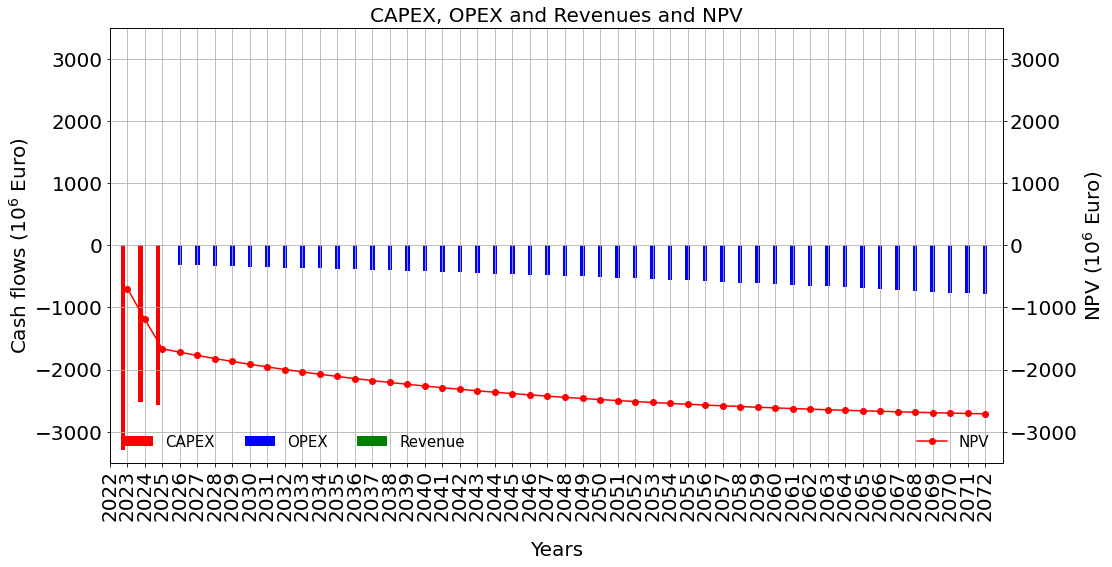

In [19]:
%%time
lims = [-3500, 3500]
create_npv_plot(df_npv_Foundations, cash_flow_lims=lims, npv_lims=lims)

In [20]:
%%time
df_Turbines = Inputs_2_cashflow(Inputs, 
                                   startyear=2023,
                                   lifecycle=11,
                                   subsystem='Wind energy source & Transport',
                                   element='Offshore wind park',
                                   component='Turbine',
                                   Debug=True)
df_Turbines.head()

'Escalation base year Turbine: 2023'

'Escalation rate Turbine: 0.02'

'Number of units Turbine: 3000 MW'

'Construction duration Turbine: 3 years'

'Construction allocation Turbine: [0.4, 0.3, 0.3] per year'

'Economic Lifetime Turbine: 50 years'

'Depreciation Flag Turbine: 1'

'Yearly Variable Costs Flag Turbine: 1'

'Yearly Variable Costs Rate Turbine: 0.03'

'Insurance Flag Turbine: 1'

'Insurance Rate Turbine: 0.005'

'Decommissioning Turbine: 0.02'

'Residual Value Turbine: 0.01'

'Escalation years: [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072]'

'Escalation values: [1.02, 1.0404, 1.061208, 1.08243216, 1.1040808032, 1.126162419264, 1.14868566764928, 1.1716593810022657, 1.195092568622311, 1.2189944199947573, 1.2433743083946525, 1.2682417945625455, 1.2936066304537963, 1.3194787630628724, 1.3458683383241299, 1.3727857050906125, 1.4002414191924248, 1.4282462475762734, 1.4568111725277988, 1.485947395978355, 1.515666343897922, 1.5459796707758806, 1.5768992641913981, 1.6084372494752261, 1.6406059944647307, 1.6734181143540252, 1.7068864766411058, 1.741024206173928, 1.7758446902974065, 1.8113615841033548, 1.847588815785422, 1.8845405921011305, 1.9222314039431532, 1.9606760320220162, 1.9998895526624565, 2.0398873437157055, 2.08068509059002, 2.1222987924018204, 2.164744768249857, 2.208039663614854, 2.252200456887151, 2.297244466024894, 2.343189355345392, 2.3900531424522997, 2.437854205301346, 2.4866112894073726, 2.53634351519552, 2.5870703854994304, 2.638811793209419, 2.6915880290736074]'

'CAPEX total Turbine: 1495000 eu per MW'

'CAPEX years: [2023, 2024, 2025]'

'CAPEX values: [-1794000000.0, -1345500000.0, -1345500000.0]'

'CAPEX years escalated: [2023, 2024, 2025]'

'CAPEX values escalated: [-1829880000.0, -1399858200.0, -1427855364.0]'

'OPEX value: -163015774.73999998'

'OPEX years escalated: [2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072]'

'OPEX values escalated: [-176453517.16589162, -179982587.50920945, -183582239.25939366, -187253884.0445815, -190998961.72547317, -194818940.95998263, -198715319.77918229, -202689626.17476594, -206743418.69826126, -210878287.07222646, -215095852.81367102, -219397769.86994445, -223785725.26734334, -228261439.7726902, -232826668.56814402, -237483201.9395069, -242232865.97829705, -247077523.297863, -252019073.7638203, -257059455.23909667, -262200644.34387863, -267444657.2307562, -272793550.3753713, -278249421.3828787, -283814409.8105363, -289490698.00674707, -295280511.966882, -301186122.2062197, -307209844.6503441, -313354041.543351, -319621122.374218, -326013544.82170236, -332533815.71813637, -339184492.03249913, -345968181.87314916, -352887545.51061213, -359945296.42082435, -367144202.34924084, -374487086.39622563, -381976828.12415016, -389616364.68663317, -397408691.9803659, -405356865.8199732, -413464003.1363726, -421733283.1991001, -430167948.86308205, -438771307.8403437]'

0
2023
-1829880000.0
1
2024
-1399858200.0
2
2025
-1427855364.0
CPU times: total: 109 ms
Wall time: 91.5 ms


,years,capex,opex,revenue
years,,,,
2023,2023,-1829880000,0.000000e+00,0
2024,2024,-1399858200,0.000000e+00,0
2025,2025,-1427855364,0.000000e+00,0
2026,2026,0,-1.764535e+08,0
2027,2027,0,-1.799826e+08,0


In [21]:
%%time
df_npv_Turbines = calculate_npv(df_Turbines)
df_npv_Turbines.head()

CPU times: total: 15.6 ms
Wall time: 12.1 ms


,years,capex,opex,revenue,cashflow,cashflow_sum,npv,npv_sum
years,,,,,,,,
2023,2023,-1829880000,0.000000e+00,0,-1.829880e+09,-1.829880e+09,-3.860075e+08,-3.860075e+08
2024,2024,-1399858200,0.000000e+00,0,-1.399858e+09,-3.229738e+09,-2.759773e+08,-6.619848e+08
2025,2025,-1427855364,0.000000e+00,0,-1.427855e+09,-4.657594e+09,-2.630812e+08,-9.250660e+08
2026,2026,0,-1.764535e+08,0,-1.764535e+08,-4.834047e+09,-3.038450e+07,-9.554505e+08
2027,2027,0,-1.799826e+08,0,-1.799826e+08,-5.014030e+09,-2.896466e+07,-9.844151e+08


CPU times: total: 2.8 s
Wall time: 2.94 s


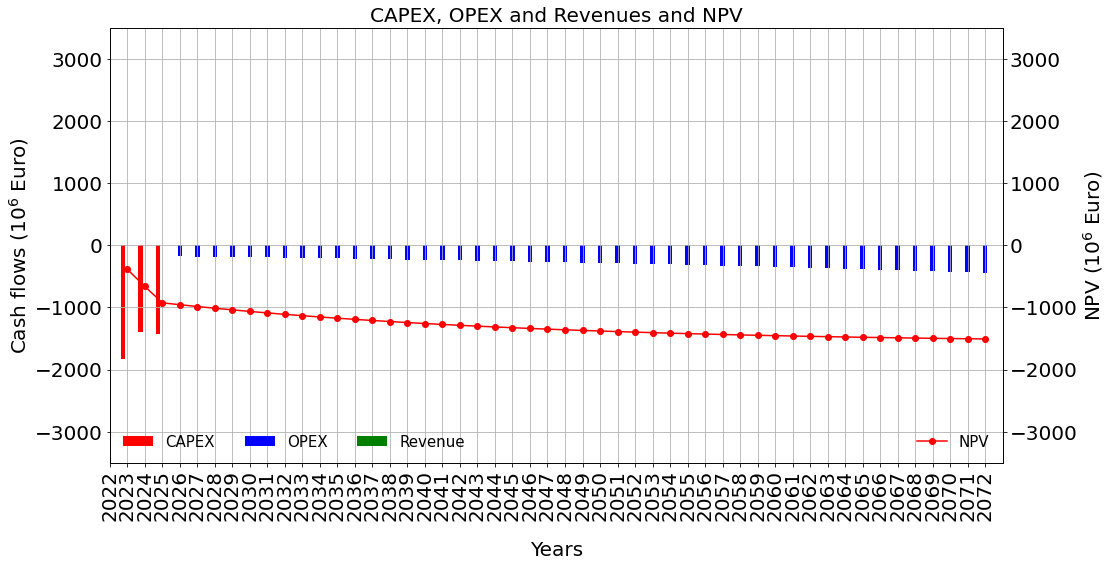

In [22]:
%%time
lims = [-3500, 3500]
create_npv_plot(df_npv_Turbines, cash_flow_lims=lims, npv_lims=lims)

##### B. combine two items

In [23]:
df_Foundations = Inputs_2_cashflow(Inputs, startyear=2023, lifecycle=11, component='Foundation & cable',Debug=False)
df_Turbines = Inputs_2_cashflow(Inputs, startyear=2023, lifecycle=11, component='Turbine',Debug=False)
df_combined = combine_cashflow_dataframes([df_Foundations, df_Turbines])

0
2023
-3293784000.0
1
2024
-2519744760.0
2
2025
-2570139655.2
0
2023
-1829880000.0
1
2024
-1399858200.0
2
2025
-1427855364.0


In [24]:
df_npv_combined = calculate_npv(df_combined)

CPU times: total: 2.97 s
Wall time: 3.03 s


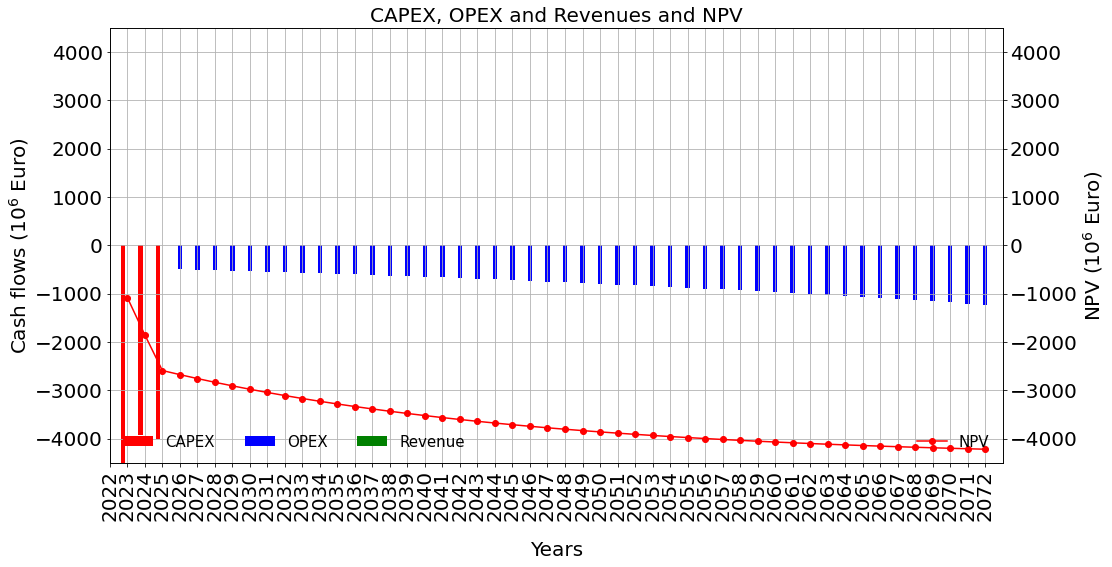

In [25]:
%%time
lims = [-4500, 4500]
create_npv_plot(df_npv_combined, cash_flow_lims=lims, npv_lims=lims)